In [1]:
import os
import numpy as np
from PIL import Image
from icecream import ic # icecream is a debugging tool. See https://github.com/gruns/icecream
import matplotlib.pyplot as plt
from torch.utils.data import Dataset


## Download data

Dataset is in https://drive.google.com/file/d/1AUkcQzHuB6EMa0OBMAahYRzxl_Vtik0-/view?usp=drive_link

In [2]:
train_input_path = "images/Images_Train/Image_Train.tif"
train_reference_path = "images/Images_Train/Reference_Train.tif"

test_input_path = "images/Images_Test/Image_Test.tif"
test_reference_path = "images/Images_Test/Reference_Test.tif"


In [3]:
def read_tiff(tiff_file):
    data = np.array(Image.open(tiff_file))
    return data

In [4]:
im_train = read_tiff(train_input_path)
reference_train_rgb = read_tiff(train_reference_path)

im_test = read_tiff(test_input_path)
reference_test_rgb = read_tiff(test_reference_path)

ic(im_train.shape, reference_train_rgb.shape)
ic(im_test.shape, reference_test_rgb.shape)


ic| im_train.shape: (2565, 1919, 3)
    reference_train_rgb.shape: (2565, 1919, 3)
ic| im_test.shape: (2558, 2818, 3)
    reference_test_rgb.shape: (2558, 2818, 3)


((2558, 2818, 3), (2558, 2818, 3))

## Classes are:

0.   Impervious surfaces (RGB: 255, 255, 255)
1.   Building (RGB: 0, 0, 255)
2.   Low vegetation (RGB: 0, 255, 255)
3.   Tree (RGB: 0, 255, 0)
4.   Car (RGB: 255, 255, 0)







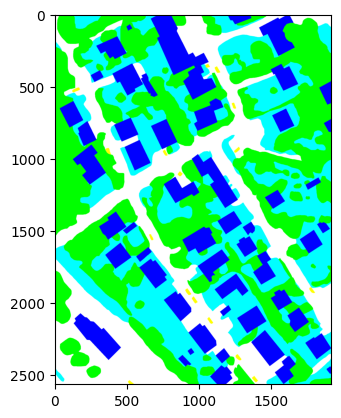

In [5]:
plt.imshow(reference_train_rgb)

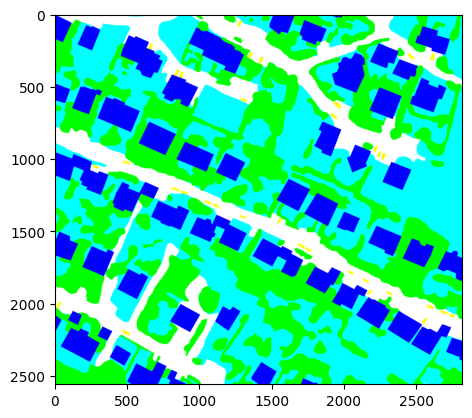

In [6]:
plt.imshow(reference_test_rgb)

## Utilities to convert reference from RGB to grayscale and from grayscale to RGB

In [7]:
def label_rgb_to_grayscale(msk):

    msk = msk.astype(np.int64)
    new = np.zeros((msk.shape[0], msk.shape[1]), dtype=np.int64)

    msk = msk // 255
    msk = msk * (1, 7, 49)
    msk = msk.sum(axis=2)

    new[msk == 1 + 7 + 49] = 0 # Street.
    new[msk ==         49] = 1 # Building.
    new[msk ==     7 + 49] = 2 # Grass.
    new[msk ==     7     ] = 3 # Tree.
    new[msk == 1 + 7     ] = 4 # Car.
    new[msk == 1         ] = 5 # Surfaces.
    new[msk == 0         ] = 6 # Boundaries.

    return new

colormap = {0: [255, 255, 255],
            1: [0, 0, 255],
            2: [0, 255, 255],
            3: [0, 255, 0],
            4: [255, 255, 0]}

def label_grayscale_to_rgb(label):

    msk = np.zeros((label.shape[0], label.shape[1], 3), dtype=np.uint8)

    for c in colormap.keys():
      msk[..., 0][label == c] = colormap[c][0]
      msk[..., 1][label == c] = colormap[c][1]
      msk[..., 2][label == c] = colormap[c][2]

    return msk

In [8]:
reference_train = label_rgb_to_grayscale(reference_train_rgb)
reference_test = label_rgb_to_grayscale(reference_test_rgb)


In [9]:
ic(reference_train.shape)

ic| reference_train.shape: (2565, 1919)


(2565, 1919)

## Visualize dataset

ic| np.unique(reference_train, return_counts=True): (array([0, 1, 2, 3, 4]), array([1132698,  867583, 1255273, 1653521,   13160]))
ic| np.unique(reference_test, return_counts=True): (array([0, 1, 2, 3, 4]), array([1185224, 1302768, 2549104, 2144306,   27042]))


Text(0.5, 1.0, 'reference test')

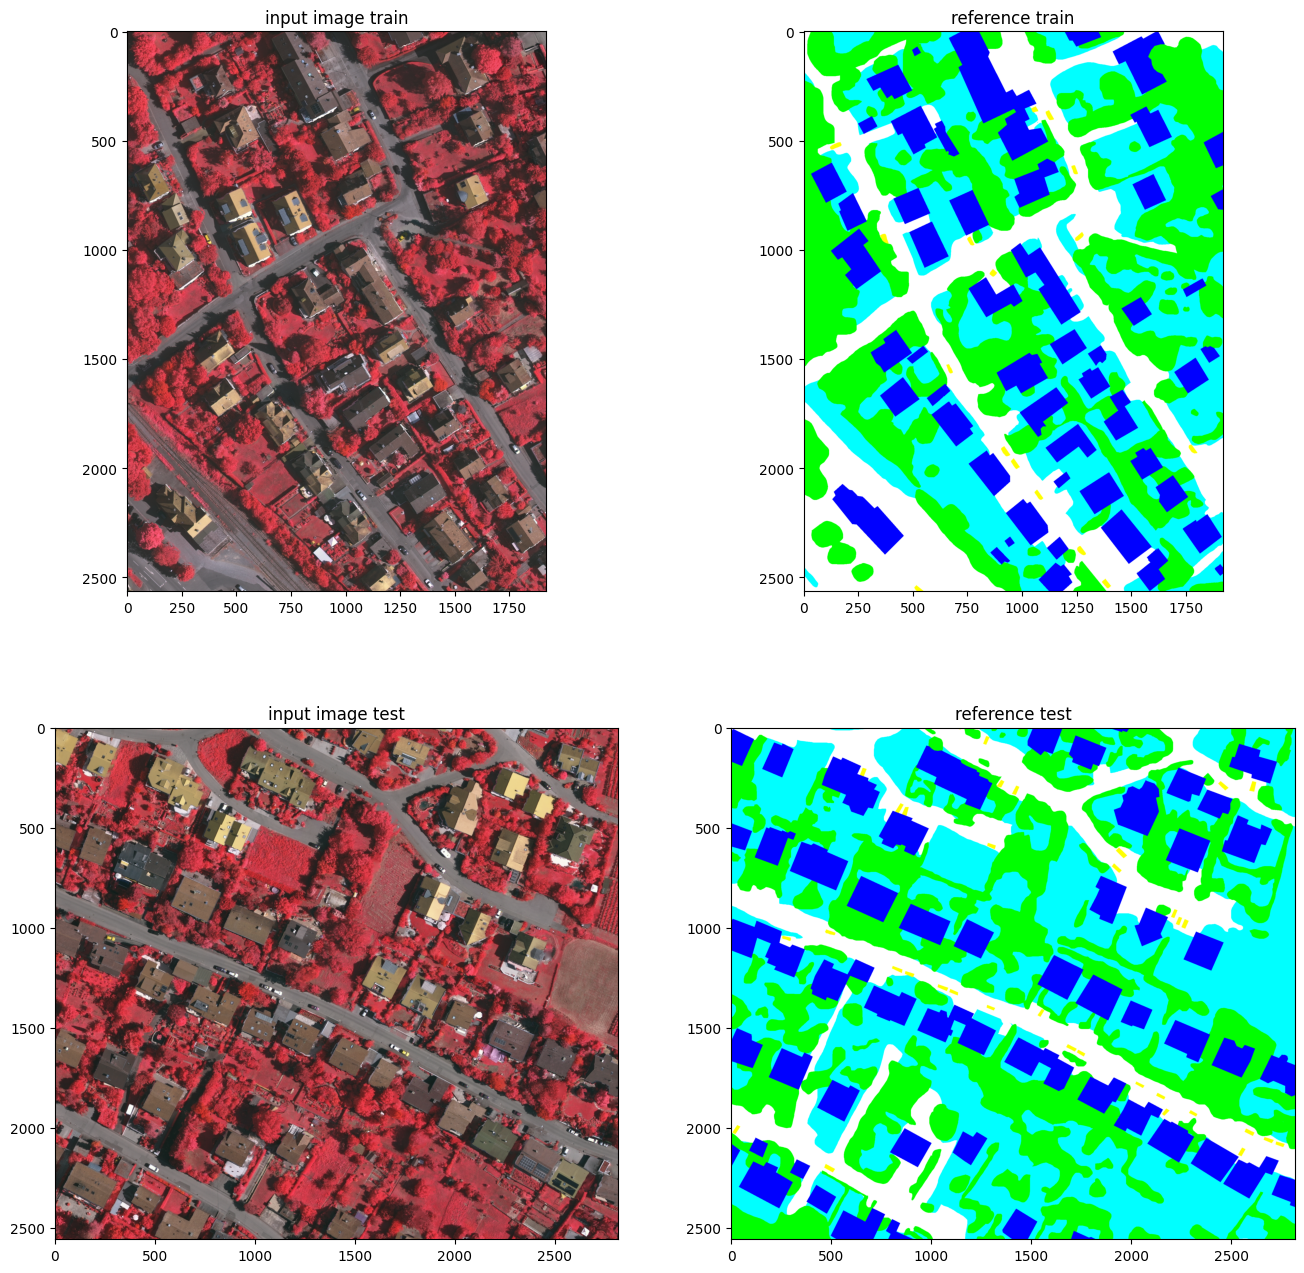

In [10]:
ic(np.unique(reference_train, return_counts=True))
ic(np.unique(reference_test, return_counts=True))

plt.figure(figsize=(16, 16))
plt.subplot(221)
plt.imshow(im_train/255)
plt.title('input image train')
plt.subplot(222)
plt.imshow(reference_train_rgb)
plt.title('reference train')

plt.subplot(223)
plt.imshow(im_test/255)
plt.title('input image test')

plt.subplot(224)
plt.imshow(reference_test_rgb)
plt.title('reference test')

## Extract image patches

We use `view_as_windows` from `skimage`. See the documentation https://scikit-image.org/docs/stable/api/skimage.util.html#skimage.util.view_as_windows

In [11]:
from skimage.util import view_as_windows
channel_n = 3
patch_len = 128

train_step = patch_len//2

ic(im_train.shape)

im_train_patch = view_as_windows(im_train, (patch_len, patch_len, channel_n), step=train_step)
reference_train_patch = view_as_windows(reference_train, (patch_len, patch_len), step=train_step)

#del im_train, reference_train

im_train_patch = im_train_patch.reshape(-1, patch_len, patch_len, channel_n)
reference_train_patch = reference_train_patch.reshape(-1, patch_len, patch_len)

ic(im_train_patch.shape)
ic(reference_train_patch.shape)

print("Number of training patches:", im_train_patch.shape[0])

ic| im_train.shape: (2565, 1919, 3)
ic| im_train_patch.shape: (1092, 128, 128, 3)
ic| reference_train_patch.shape: (1092, 128, 128)


Number of training patches: 1092


## Convert labels to one-hot

In [12]:
class_n = len(np.unique(reference_train))
ic(np.unique(reference_test))
def to_one_hot(reference, class_n):
    b = np.zeros((reference.size, class_n))
    b[np.arange(reference.size), reference] = 1
    return b

def patches_to_one_hot(reference_patch, class_n):
    shape = reference_patch.shape
    reference_patch = to_one_hot(reference_patch.flatten(), class_n)
    reference_patch = reference_patch.reshape((*shape, class_n))
    return reference_patch

reference_train_patch = patches_to_one_hot(reference_train_patch, class_n)
ic(reference_train_patch.shape)
ic(class_n)


ic| np.unique(reference_test): array([0, 1, 2, 3, 4])
ic| reference_train_patch.shape: (1092, 128, 128, 5)
ic| class_n: 5


5

## Split training patches into 80% for training and 20% for validation

In [13]:
from torch.utils.data import DataLoader
from sklearn.model_selection import train_test_split
import torch

# Assuming your train input and reference are already tensors
train_input = im_train_patch
train_reference = reference_train_patch

# Split data into training and validation sets (80%/20%)
train_input, val_input, train_reference, val_reference = train_test_split(train_input, train_reference, test_size=0.2, random_state=42)


## Define the Pytorch DataLoader for training and validation

Hint: Remember to normalize the input images. Each encoder has its own normalization parameters, obtained as:

`params = smp.encoders.get_preprocessing_params(encoder_name)`

Where mean and std parameters will be `params['mean']` and `params['std']`, respectively.

See the class hands-on for more details.

In [14]:
from torchvision import transforms
import segmentation_models_pytorch as smp

encoder_name = 'resnet34'
params = smp.encoders.get_preprocessing_params(encoder_name)
# mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]
mean = params['mean']
std = params['std']

# Define separate datasets for training and validation
class CustomDataset(Dataset):
    def __init__(self, input, reference, transform=None, transform_reference=None):
        self.input = input
        self.reference = reference
        self.transform = transform
        self.transform_reference = transform_reference
    def __len__(self):
        return len(self.input)

    def __getitem__(self, idx):
        image = self.input[idx]
        label = self.reference[idx]
        # Apply the transform to the image
        if self.transform is not None:
            image = self.transform(image)
        if self.transform_reference is not None:
            label = self.transform_reference(label)
        return image, label


# Define a transform that first converts the image to a tensor and then normalizes it
transform = transforms.Compose([
    transforms.ToTensor(),  # Converts to tensor
    transforms.Normalize(mean=mean, std=std)  # Normalize
])

transform_reference = transforms.ToTensor()

# Create training and validation dataset instances
train_dataset = CustomDataset(train_input, train_reference, transform=transform, transform_reference=transform_reference)
val_dataset = CustomDataset(val_input, val_reference, transform=transform, transform_reference=transform_reference)


# Create separate DataLoaders for training and validation
train_batch_size = 64 # Adjust batch_size as needed
train_loader = DataLoader(train_dataset, batch_size=train_batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=1, shuffle=False)  # Don't shuffle validation data

## Define your model using SMP

In [ ]:
from torch.utils.tensorboard import SummaryWriter
import time

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
#class_n = 5

# You: Define model architecture
# encoder_name = 'resnet34'
model = smp.Unet(encoder_name = encoder_name,
                 encoder_weights = 'imagenet',
                 in_channels=channel_n,
                 classes=class_n).to(device)
timestamp = time.strftime("%Y-%m-%d_%H.%M.%S", time.localtime())
running_epoch = 0


In [ ]:
import torchinfo
torchinfo.summary(model, input_size=(train_batch_size, channel_n, patch_len, patch_len), device="cuda")

Layer (type:depth-idx)                        Output Shape              Param #
Unet                                          [32, 5, 128, 128]         --
├─ResNetEncoder: 1-1                          [32, 3, 128, 128]         --
│    └─Conv2d: 2-1                            [32, 64, 64, 64]          9,408
│    └─BatchNorm2d: 2-2                       [32, 64, 64, 64]          128
│    └─ReLU: 2-3                              [32, 64, 64, 64]          --
│    └─MaxPool2d: 2-4                         [32, 64, 32, 32]          --
│    └─Sequential: 2-5                        [32, 64, 32, 32]          --
│    │    └─BasicBlock: 3-1                   [32, 64, 32, 32]          73,984
│    │    └─BasicBlock: 3-2                   [32, 64, 32, 32]          73,984
│    │    └─BasicBlock: 3-3                   [32, 64, 32, 32]          73,984
│    └─Sequential: 2-6                        [32, 128, 16, 16]         --
│    │    └─BasicBlock: 3-4                   [32, 128, 16, 16]         230,144

In [17]:
import torchvision
from torchview import draw_graph

model_graph = draw_graph(model, input_size=(1, channel_n, patch_len, patch_len))  # Add batch size of 1
model_graph.visual_graph.render(filename='model_graph', format='png', cleanup=True, renderer='cairo')  # Save the graph as a PNG file


(process:6316): Pango-WARNING **: 16:28:46.312: couldn't load font "Linux libertine Not-Rotated 10", falling back to "Sans Not-Rotated 10", expect ugly output.


'model_graph.cairo.png'

## Definition of early stopping.

Use as in the next example https://github.com/Bjarten/early-stopping-pytorch/blob/master/MNIST_Early_Stopping_example.ipynb

In [18]:
class EarlyStopping:
    """Early stops the training if validation loss doesn't improve after a given patience."""
    def __init__(self, patience=7, verbose=False, delta=0, path='checkpoint.pt', trace_func=print):
        """
        Args:
            patience (int): How long to wait after last time validation loss improved.
                            Default: 7
            verbose (bool): If True, prints a message for each validation loss improvement.
                            Default: False
            delta (float): Minimum change in the monitored quantity to qualify as an improvement.
                            Default: 0
            path (str): Path for the checkpoint to be saved to.
                            Default: 'checkpoint.pt'
            trace_func (function): trace print function.
                            Default: print
        """
        self.patience = patience
        self.verbose = verbose
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.val_loss_min = np.inf
        self.delta = delta
        self.path = path
        self.trace_func = trace_func
    def __call__(self, val_loss, model):

        score = -val_loss

        if self.best_score is None:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
        elif score < self.best_score + self.delta:
            self.counter += 1
            self.trace_func(f'EarlyStopping counter: {self.counter} out of {self.patience}')
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
            self.counter = 0

    def save_checkpoint(self, val_loss, model):
        '''Saves model when validation loss decrease.'''
        if self.verbose:
            self.trace_func(f'Validation loss decreased ({self.val_loss_min:.6f} --> {val_loss:.6f}).  Saving model ...')
        torch.save(model.state_dict(), self.path)
        self.val_loss_min = val_loss

## Define your training loop.

1. You can reuse code from the class hands-on https://colab.research.google.com/drive/1XVEgeZotsafKc5cQJI8I4_sPygcsd_q4?usp=sharing

2. The next link contains another training example using Pytorch. Use early stopping on the validation set as in https://github.com/Bjarten/early-stopping-pytorch/blob/master/MNIST_Early_Stopping_example.ipynb


In [ ]:
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
early_stopping = EarlyStopping(patience=10, verbose=True, path='logs\\models\\'+timestamp+'\\best_model.pth')
num_epochs = 2000

try:
    # Initialize TensorBoard writer
    
    board = SummaryWriter(log_dir='logs\\' + timestamp) # Create a new log directory for each run

    for epoch in range(running_epoch, running_epoch + num_epochs):  # Adjust the number of epochs as needed
        total_train_loss = 0.0

        start_time = time.time()
        model.train()  # Set the model to training mode
        for train_batch, refence_batch in train_loader:
            # Move the data to the device (GPU or CPU)
            train_batch = train_batch.to(device)
            refence_batch = refence_batch.to(device)

            # Forward pass
            outputs = model(train_batch)

            # Compute loss (example using CrossEntropyLoss)
            criterion = torch.nn.CrossEntropyLoss()
            loss = criterion(outputs, refence_batch)

            # Backward pass and optimization
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            total_train_loss += loss.item()
        train_loss = total_train_loss / len(train_loader)

        total_val_loss = 0.0
        with torch.no_grad():
            model.eval()  # Set the model to evaluation mode
            for val_batch, refence_batch in val_loader:
                # Move the data to the device (GPU or CPU)
                val_batch = val_batch.to(device)
                refence_batch = refence_batch.to(device)

                # Forward pass
                outputs = model(val_batch)

                # Compute loss (example using CrossEntropyLoss)
                criterion = torch.nn.CrossEntropyLoss()
                loss = criterion(outputs, refence_batch)

                total_val_loss += loss.item()
        validation_loss = total_val_loss / len(val_loader)

        board.add_scalars("Curves/Loss", {"Train": train_loss, "Validation": validation_loss}, epoch)
        for name, params in model.named_parameters():
            board.add_histogram(f"Layer Gradients/{name}", params.grad, epoch)

        end_time = time.time()
        elapsed_time = end_time - start_time

        print(f"Finished epoch {epoch+1}/{running_epoch + num_epochs}, Train Loss: {train_loss:.4f}, Validation Loss: {validation_loss:.4f}, Time: {elapsed_time:.2f}s")

        # Early stopping check
        early_stopping(total_val_loss, model)
        if early_stopping.early_stop:
            print("Early stopping")
            break 
        
except KeyboardInterrupt:
    print("Training interrupted")
finally:
    # Keep track of the number of epochs completed
    running_epoch = epoch + 1
    board.close()
    

Finished epoch 1/2000, Train Loss: 1.6832, Validation Loss: 2.0749, Time: 80.89s
Validation loss decreased (inf --> 454.404981).  Saving model ...
Finished epoch 2/2000, Train Loss: 1.2842, Validation Loss: 1.2209, Time: 87.23s
Validation loss decreased (454.404981 --> 267.366673).  Saving model ...
Finished epoch 3/2000, Train Loss: 1.0667, Validation Loss: 1.0756, Time: 76.07s
Validation loss decreased (267.366673 --> 235.566330).  Saving model ...
Finished epoch 4/2000, Train Loss: 0.8895, Validation Loss: 0.9131, Time: 74.22s
Validation loss decreased (235.566330 --> 199.974079).  Saving model ...
Finished epoch 5/2000, Train Loss: 0.7328, Validation Loss: 0.7994, Time: 82.85s
Validation loss decreased (199.974079 --> 175.067410).  Saving model ...
Finished epoch 6/2000, Train Loss: 0.6173, Validation Loss: 0.6867, Time: 75.68s
Validation loss decreased (175.067410 --> 150.386431).  Saving model ...
Finished epoch 7/2000, Train Loss: 0.5396, Validation Loss: 0.6150, Time: 85.91s
Va

In [38]:
timestamp

'2025-04-20_14.52.54'

In [33]:
!tensorboard --logdir logs/2025-04-20_14.52.54

^C


## Evaluate the test set

The function `patch_inference()` performs inference on an image using a patch-based approach. If you have any problems with this function, please contact me at cmjorgeandres@gmail.com.

In [23]:
def patch_inference(image, model, patch_len, overlap_percentage, class_n, device):

    """
    This function performs inference on an image using a patch-based approach.

    Args:
        image: A NumPy array representing the input image. Expected shape is (height, width, channels).
        model: A PyTorch model for making predictions on image patches.
        patch_len: The size (length and width) of square image patches to use.
        overlap_percentage: The percentage overlap between consecutive patches (0 to 1).

    Returns:
        A NumPy array representing the predicted probability map for each class.
        The shape will match the original image.
    """
    model.to(device)
    model.eval()

    rows, cols, _ = image.shape
    """
    Everything  in this function is made operating with
    the upper left corner of the patch
    """

    # Percent of overlap between consecutive patches.
    overlap = round(patch_len * overlap_percentage)
    overlap -= overlap % 2
    stride = patch_len - overlap
    # Add Padding to the image to match with the patch size
    step_row = (stride - rows % stride) % stride
    step_col = (stride - cols % stride) % stride
    pad_tuple_msk = ( (overlap//2, overlap//2 + step_row), ((overlap//2, overlap//2 + step_col)), (0,0) )
    image_pad = np.pad(image, pad_tuple_msk, mode = 'symmetric')
    row_pad, col_pad, _ = image_pad.shape

    output_mosaic = np.zeros((row_pad,col_pad,class_n))

    k1, k2 = (rows+step_row)//stride, (cols+step_col)//stride
    print('Total number of patches: %d x %d' %(k1, k2))


    for i in range(k1):
        for j in range(k2):

            # Get input image patch
            patch = image_pad[i*stride:i*stride + patch_len, j*stride:j*stride + patch_len] # shape: (patch_len, patch_len, class_n)

            patch = np.transpose(patch, (2, 0, 1)) # shape: (class_n, patch_len, patch_len)
            patch = patch.reshape((1,channel_n,patch_len,patch_len)) # shape: (1, class_n, patch_len, patch_len)

            # convert patch to Torch tensor
            patch = torch.from_numpy(patch).float()
            patch = patch.to(device)

            pred_prob_patch = model(patch)
            pred_prob_patch = pred_prob_patch.squeeze().cpu().detach().numpy().squeeze() # shape: (class_n, patch_len, patch_len)


            pred_prob_patch = np.transpose(pred_prob_patch, (1,2,0)) # shape: (patch_len, patch_len, class_n)

            output_mosaic[i*stride:i*stride + patch_len, j*stride:j*stride + patch_len,:] = pred_prob_patch.copy()
    output_mosaic = output_mosaic[:image.shape[0], :image.shape[1]] # unpad result
    return output_mosaic

`overlap_percentage` indicates the amount of overlap between inference sub-images. A larger overlap may yield a better result, but may result in higher processing times.

Hint: Remember to normalize the input images before running inference. Each encoder has its own normalization parameters, obtained as:

`params = smp.encoders.get_preprocessing_params(encoder_name)`

Where mean and std parameters will be `params['mean']` and `params['std']`, respectively.

See the class hands-on for more details.

In [24]:
def normalize_image(image, mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]):
    #transform = transforms.Normalize(mean=mean, std=std)  # Normalize
    image = image.astype(np.float32) / 255.0
    image = (image - mean) / std
    return image


In [25]:
params = smp.encoders.get_preprocessing_params(encoder_name)
params

{'input_space': 'RGB',
 'input_range': [0, 1],
 'mean': [0.485, 0.456, 0.406],
 'std': [0.229, 0.224, 0.225]}

In [26]:
im_test_norm = normalize_image(im_test, mean=mean, std=std) # You: Normalize input image
im_test_norm.shape, im_test.shape

((2558, 2818, 3), (2558, 2818, 3))

In [34]:
overlap_percentage = 0.5

#model = smp.Unet(encoder_name=encoder_name, encoder_weights='imagenet', in_channels=channel_n, classes=class_n).to(device)
#timestamp = "2025-04-20_14.52.54" # 32 batch-size model after training
state_dict = torch.load("logs\\models\\" + timestamp + "\\best_model.pth")  # Load the state dictionary
model.load_state_dict(state_dict)  # Apply the state dictionary to the model

result_raw = patch_inference(im_test_norm, model, patch_len=128,
                                    overlap_percentage=overlap_percentage,
                                    class_n=class_n,
                                    device=device)
result_raw.shape, im_test.shape

Total number of patches: 40 x 45


((2558, 2818, 5), (2558, 2818, 3))

In [35]:
result = result_raw.argmax(axis=-1) # Pick the class with the highest probability
result_rgb = label_grayscale_to_rgb(result) # Convert to RGB for visualization
result.shape, result_rgb.shape

((2558, 2818), (2558, 2818, 3))

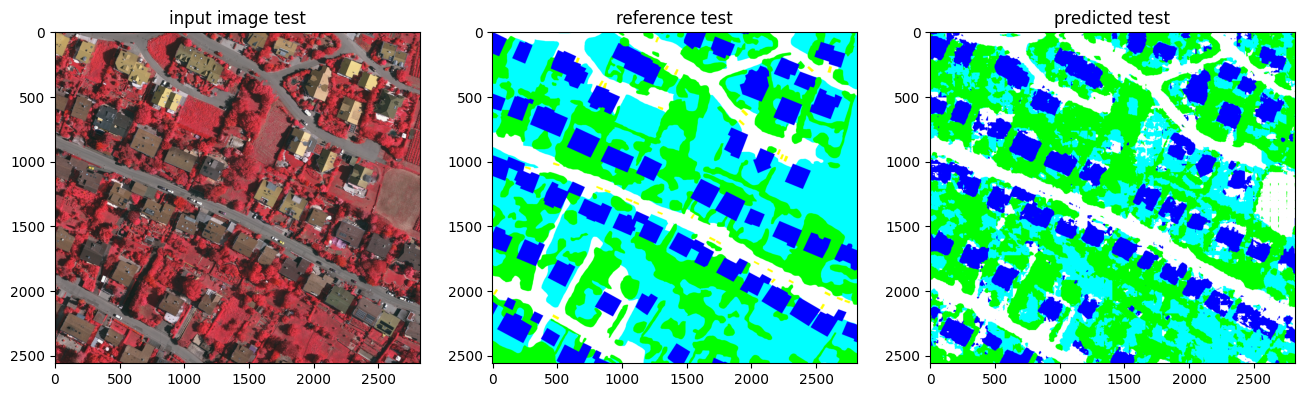

In [36]:
plt.figure(figsize=(16, 16))
plt.subplot(131)
plt.imshow(im_test/255)
plt.title('input image test')

plt.subplot(132)
plt.imshow(reference_test_rgb)
plt.title('reference test')

plt.subplot(133)
plt.imshow(result_rgb)
plt.title('predicted test')
plt.show()

## Calculate test metrics
Metrics must be calculated on the reconstructed (large) image

Hint: Use sklearn library

* Accuracy: sklearn.metrics.accuracy_score https://scikit-learn.org/stable/modules/generated/sklearn.metrics.accuracy_score.html
* F1-score: sklearn.metrics.f1_score: Use average=None for individual per-class values. Use average='macro' for class average F1-score. https://scikit-learn.org/stable/modules/generated/sklearn.metrics.f1_score.html
* mIoU: sklearn.metrics.jaccard_score: Use average='macro' for mIoU (Mean intersection over union) https://scikit-learn.org/stable/modules/generated/sklearn.metrics.jaccard_score.html

In [37]:
# You: Calculate test metrics. Hint: Use sklearn library
# Use as "y_true" the variable "reference_test", and as "y_pred" the variable "result"
import sklearn.metrics as metrics

accuracy = metrics.accuracy_score(reference_test.flatten(), result.flatten())
f1_score1 = metrics.f1_score(reference_test.flatten(), result.flatten(), average=None)
f1_score2 = metrics.f1_score(reference_test.flatten(), result.flatten(), average='macro')
miou = metrics.jaccard_score(reference_test.flatten(), result.flatten(), average='macro')

accuracy, f1_score1, f1_score2, miou

(0.5732671294942432,
 array([0.62678808, 0.63500916, 0.48911854, 0.58528489, 0.        ]),
 0.467240134603277,
 np.float64(0.33181870366820937))